In [3]:
# import necessary packages
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import cv2

from tqdm.auto import tqdm
from ipywidgets import FloatProgress
from scipy import ndimage
from PIL import Image
from importlib import reload

# append path
sys.path.append('../')

# custom
from utils.BuildUNet import UNet
from utils.GetLowestGPU import GetLowestGPU
from utils.TileGenerator import TileGenerator
from utils.Metrics import iou
from utils.AreaCalc import area_calc
import utils.SegmentImage as SegmentImage
import utils.MeasureLeaves as MeasureLeaves

device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 02818MiB / 40537MiB
  1  | 00003MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 00003MiB / 40537MiB
---------------------------
 Device set to cuda:1
---------------------------


In [4]:
# Load model
model_kwargs = {
    'layer_sizes': [32, 64, 128, 256, 512],
    'in_channels': 3,
    'out_channels': 4,
    'conv_per_block': 3,
    'dropout_rate': 0.1,
    'hidden_activation': torch.nn.SELU(),
    'output_activation': None,
}

unet = UNet(**model_kwargs)
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()


In [5]:
# find iteration with lowest loss
log_path = '../logs/'
log = pd.read_csv(log_path + 'log.csv')
best_loss = log.iloc[log["val_loss"].idxmin()]["iter_num"].astype(int)

In [6]:
# load model weights
checkpoint = torch.load(f"../checkpoints/checkpoint_{best_loss}.pt", map_location=device)

#extract weights from checkpoint
weights = checkpoint["model"]
# trained model has been loaded
unet.load_state_dict(weights)
unet.eval()#inference mode (no dropout, batch norm uses running mean, etc.)
unet.to(device)

UNet(
  (hidden_activation): SELU()
  (enc_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SELU()
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): SELU()
    (11): Dropout2d(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): SELU()
    

In [12]:
# load in images
# options
image_path = "../data/test/test_images/"
save_path = "../data/pop_scale/pop_scale_segmentations/"

# load image data
image_names = glob.glob(image_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

Processing 477-ref-ISU_103-rep_2-M-CORE.png


  0%|          | 0/7797 [00:00<?, ?it/s]

IndexError: index 2 is out of bounds for axis 0 with size 2

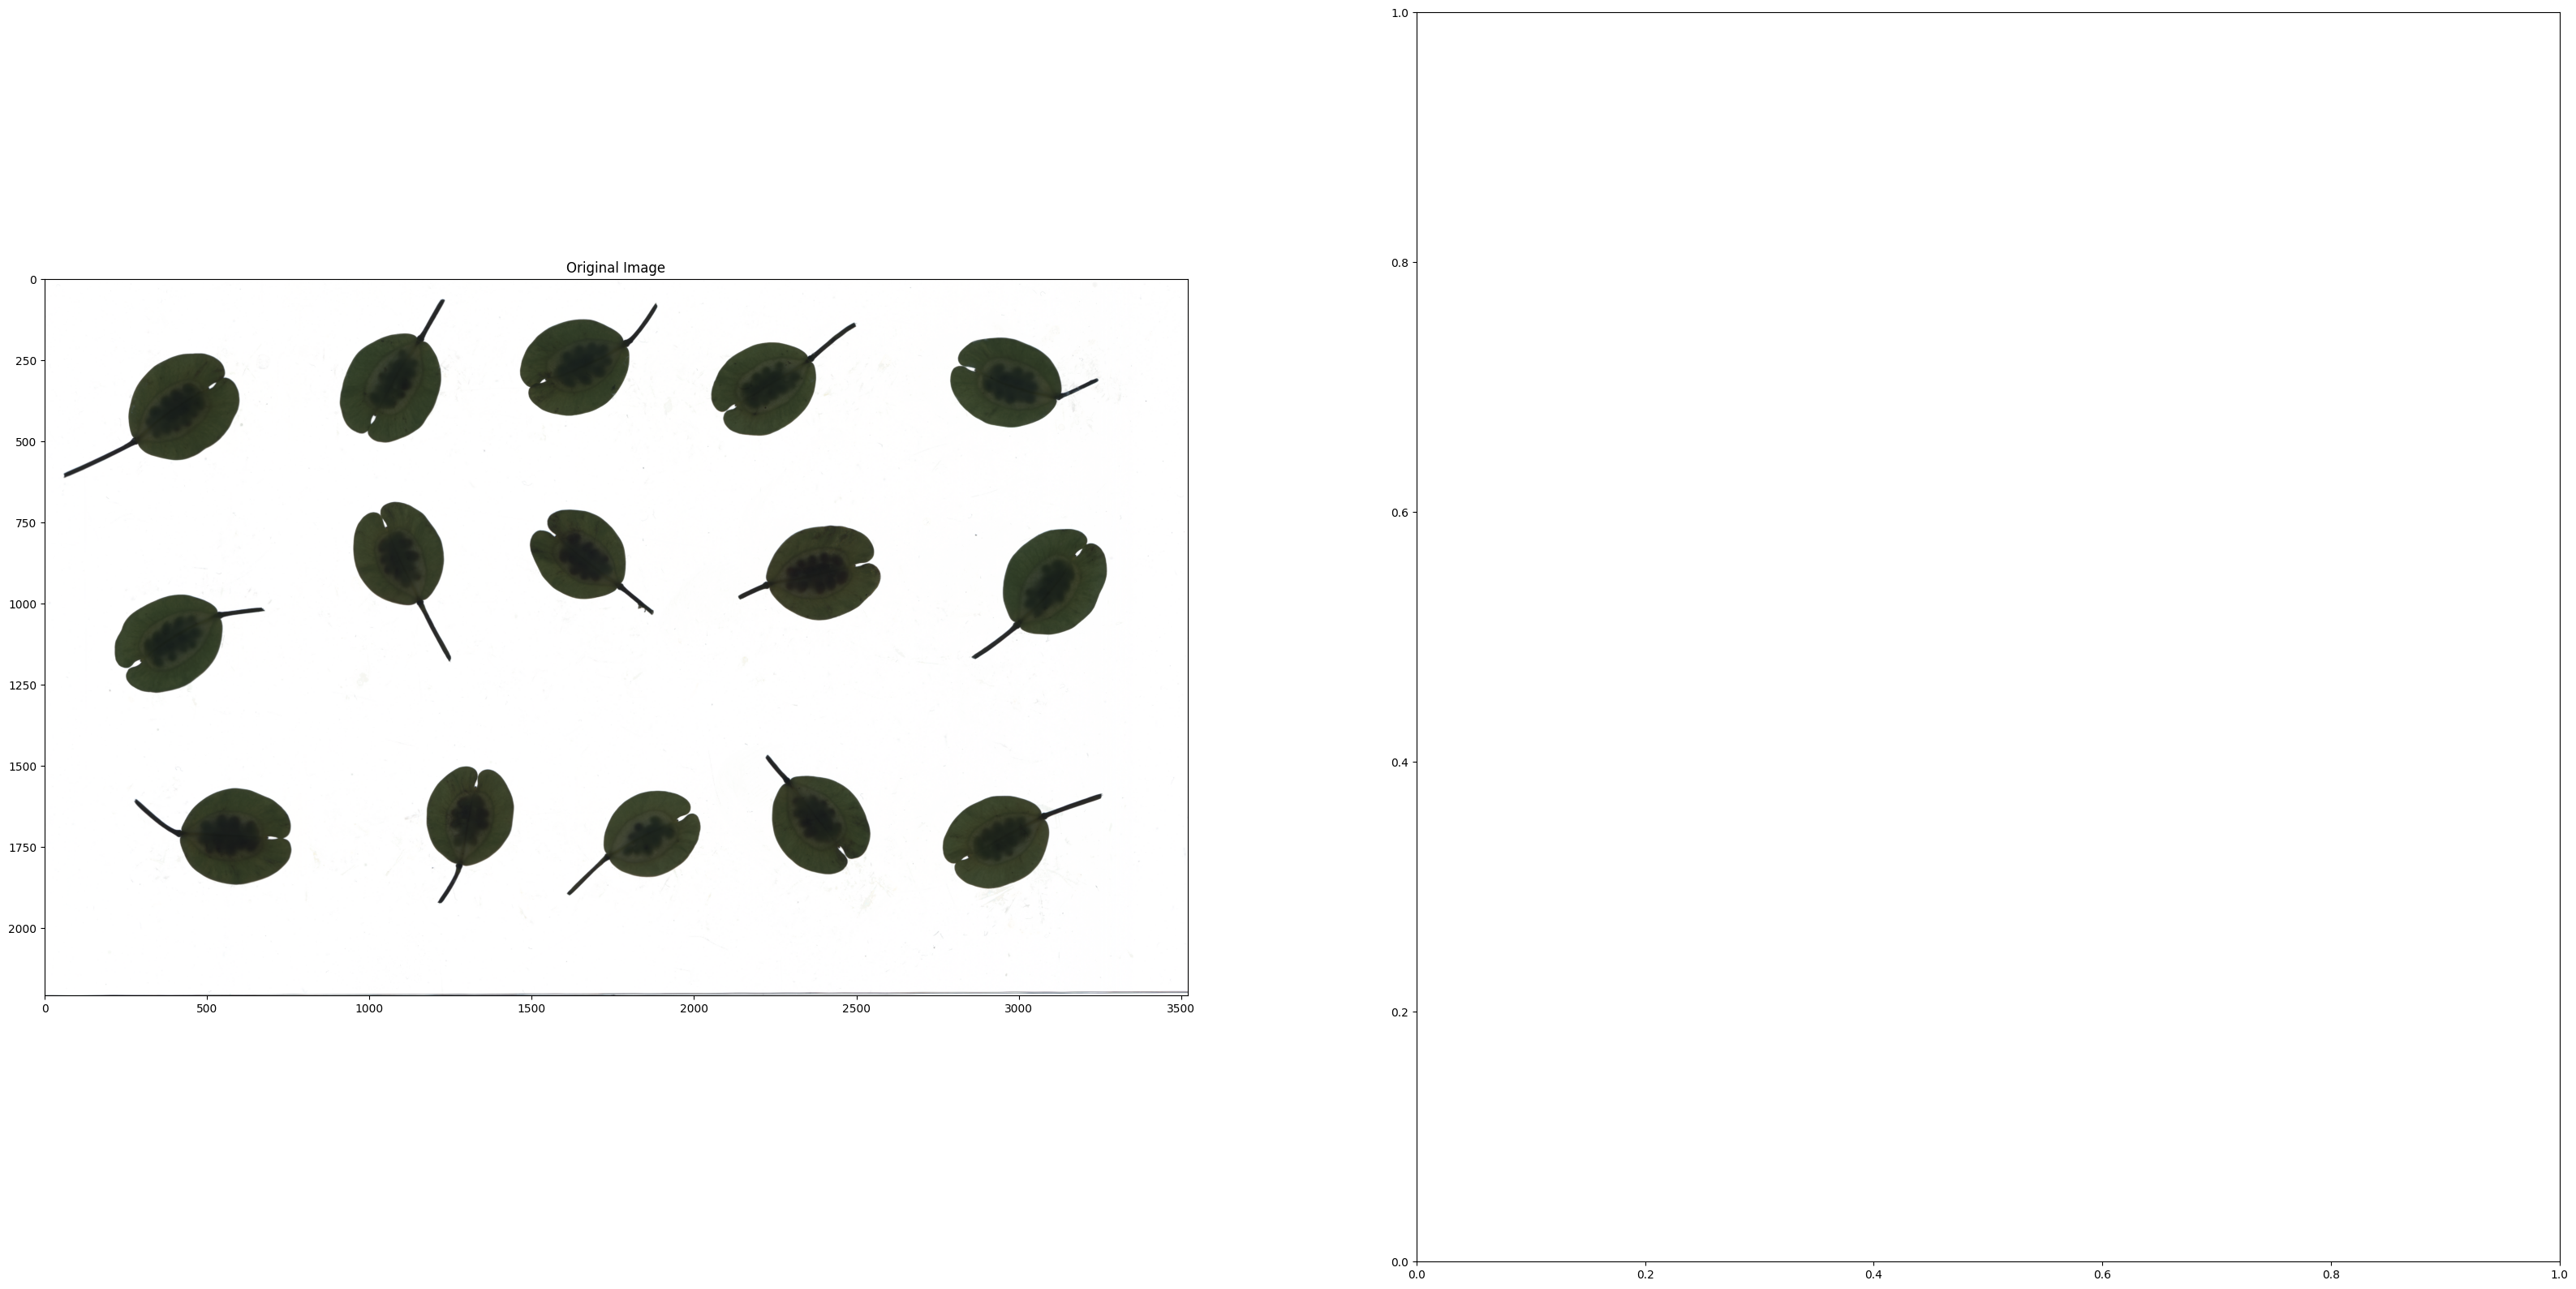

In [14]:
# run population scale prediction
reload(SegmentImage)
SegmentImage.segment_image(model = unet,
                           image_names = image_names,
                           image_path = image_path,
                           mask_path = None,
                           save_path = save_path,
                           plot = True,
                           verbose = 2,
                           device = device)